# Network eCREST



# Setup

Do the following two setup steps regardless of how you will be using this script. 

## 1. Imports

Run the following code cell to import the necessary packages and modules. 

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
import random
from random import choice as random_choice
from itertools import combinations
import itertools
from numpy import array, unravel_index, argmin, mean,unique
import matplotlib
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import datetime
from time import time, sleep
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import matplotlib.pyplot as plt
import seaborn as sns

from eCREST_cli import ecrest, import_settings

In [2]:
vx_sizes = [16, 16, 30]

def get_viewer(backgnd_color = "black"):
    viewer = neuroglancer.Viewer()
    viewer.set_state({})

    location=[17000,17000,1500]

    with viewer.config_state.txn() as s:
        s.show_layer_panel = True ###

    with viewer.txn(overwrite=True) as s:

        dimensions = neuroglancer.CoordinateSpace(
            scales=vx_sizes,# self.vx_sizes['em'],
            units='nm',
            names=['x', 'y', 'z']   )

        s.showSlices = False
        s.dimensions = dimensions
        s.position = array(location)
        s.layout = "3d"
        s.projectionScale = 30000
        s.projection_background_color= matplotlib.colors.cnames[backgnd_color]#"#000000"
        # s.projection_background_color= "#ffffff"
        s.showSlices = False

    with viewer.txn(overwrite=True) as s:
        wb_open(str(viewer))
    
    return viewer

def create_baseseg_layer(viewer, source, lname, visible = False, objectAlpha = 1):
    with viewer.txn(overwrite=True) as s:
        s.layers[lname] = neuroglancer.SegmentationLayer(source = source, segments=[], segment_colors={})
        s.layers[lname].ignoreNullVisibleSet = False
        s.layers[lname].pick = True
        s.layers[lname].selectedAlpha = 0.5 #For 2D
        s.layers[lname].objectAlpha = objectAlpha
        s.layers[lname].visible = visible
                 

def create_em_layer(viewer, source = 'brainmaps://10393113184:ell:roi450um_xyz'):
    with viewer.txn(overwrite=True) as s:
        s.layers['em'] = neuroglancer.ImageLayer(source = source)

def clear_baseseg_layer(viewer, lname):
    displayed_segs = set([str(x) for x in viewer.state.layers[lname].segments])

    # REMOVE SEGMENTS FROM NGviewer
    remove_segs = displayed_segs

    with viewer.txn(overwrite=True) as s:
        for bs in remove_segs:
            if int(bs) in s.layers[lname].segments:
                s.layers[lname].segments.remove(int(bs))

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


## 2. Settings and files

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

db_cursors = sqlite3_connect(settings_dict['db_path'], check_same_thread=False).cursor()

a = ', '.join(['base_address'])

db_cursors.execute(f'''SELECT {a} FROM addresses_table LIMIT 1''')

[base_seg] = db_cursors.fetchall()[0]


In [5]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

# em viewer

In [4]:
viewer = get_viewer(backgnd_color="white")
create_em_layer(viewer)

In [5]:
create_baseseg_layer(viewer, base_seg, 'base_segs')

In [6]:
point_type = 'reconstruct'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#888888'

# Vizualize sensory versus negative image input

In [52]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    
# all_base_seg = []
# for x in nodes:
#     cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
#     all_base_seg.extend([a for b in cell.cell_data['base_segments'].values() for a in b])

## Load graph dataframes 

In [48]:
savepath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/graphs/')

df_syn_pre = pd.read_csv(savepath / 'df_presyn.csv')
df_syn_post = pd.read_csv(savepath / 'df_postsyn.csv')

In [79]:
focal_cell_id = 299496636 #214581797 #

In [80]:
df_syn_pre[df_syn_pre['pre']==focal_cell_id]['post_type'].unique()

array(['mg2', 'sg2', 'grc', 'sgx'], dtype=object)

In [81]:
df_syn_pre[df_syn_pre['pre']==focal_cell_id]

,Unnamed: 0,pre,post,x,y,z,pre_type,post_type
418,418,299496636,215988767,332592.0,281136.0,42840.0,mg1,mg2
419,419,299496636,303166992,383808.0,295744.0,75000.0,mg1,mg2
420,420,299496636,474839189,403264.0,291696.0,64320.0,mg1,mg2
421,421,299496636,309743149,288832.0,283488.0,46080.0,mg1,sg2
422,422,299496636,309743149,290720.0,284288.0,47700.0,mg1,sg2
...,...,...,...,...,...,...,...,...
484,484,299496636,310887446,300032.0,248592.0,44670.0,mg1,grc
485,485,299496636,472517114,300416.0,257104.0,51480.0,mg1,mg2
486,486,299496636,129030308,303616.0,254112.0,51630.0,mg1,mg2
487,487,299496636,558300217,301184.0,260816.0,50100.0,mg1,mg2


## load focal cell

In [82]:
dirpath = Path(settings_dict['save_dir'])
focal_cell_fname = nodefiles[str(focal_cell_id)]#'cell_graph_214581797__2023-07-17 12.58.20.json'

cell = ecrest(settings_dict,filepath = dirpath / focal_cell_fname, launch_viewer=False)

## create viewer

In [83]:
viewer = get_viewer(backgnd_color="white")
create_em_layer(viewer)


In [86]:
lname = 'focal_cell'
create_baseseg_layer(viewer, base_seg, lname)

# structure_colors = {'unknown': '#d2b48c',
#                     'multiple': '#9c661f',
#                     'axon': '#008000',
#                     'basal dendrite': '#cd4b00',
#                     'apical dendrite': '#ff8000'
#                    } 
structure_colors = {'unknown': '#000000',
                    'multiple': '#000000',
                    'axon': '#b3b3b3',
                    'basal dendrite': '#000000',
                    'apical dendrite': '#000000'
                   } 

with viewer.txn(overwrite=True) as s:
    for dtype in cell.cell_data['base_segments'].keys():
        for bs in cell.cell_data['base_segments'][dtype]:
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = structure_colors[dtype] # blue

In [84]:
point_type = 'pre-synaptic'
p_name = 'all_pre'

with viewer.txn(overwrite=True) as s:
    s.layers[p_name] = neuroglancer.AnnotationLayer()
    s.layers[p_name].annotationColor = '#ffffff'
    

    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[p_name].annotations.append(pa)    

In [85]:
point_type = 'post-synaptic'
p_name = 'all_post'

with viewer.txn(overwrite=True) as s:
    s.layers[p_name] = neuroglancer.AnnotationLayer()
    s.layers[p_name].annotationColor = '#ffffff'
    

    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[p_name].annotations.append(pa)    

In [88]:
df_syn_post[df_syn_post['pre']==focal_cell_id][['pre','post','post_type']].value_counts().reset_index(name='weight')

,pre,post,post_type,weight
0,299496636,134616493,lf,8
1,299496636,213605530,mg2,8
2,299496636,392072123,lf,5
3,299496636,307591597,lf,4
4,299496636,393325331,lf,4
5,299496636,472284925,mg2,3
6,299496636,565183253,lf,2
7,299496636,213590737,mg1,1
8,299496636,307418797,lf,1
9,299496636,386426114,mg2,1


In [89]:
df_syn_pre[df_syn_pre['pre']==focal_cell_id][['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

,pre,post,pre_type,post_type,weight
0,299496636,387382792,mg1,mg2,5
1,299496636,45139623,mg1,sg2,4
2,299496636,221651954,mg1,sg2,3
3,299496636,472517114,mg1,mg2,3
4,299496636,472284925,mg1,mg2,3
5,299496636,472051969,mg1,mg2,3
6,299496636,386392158,mg1,mg2,3
7,299496636,310887446,mg1,grc,3
8,299496636,216952227,mg1,sg2,3
9,299496636,41809137,mg1,mg2,2


In [94]:
df_syn_pre[df_syn_pre['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(name='weight')['post_type'].value_counts().reset_index(name='ncells')

,index,ncells
0,mg2,18
1,sg2,12
2,grc,10
3,sgx,1


In [95]:
df_syn_pre[df_syn_pre['pre']==focal_cell_id]

,Unnamed: 0,pre,post,x,y,z,pre_type,post_type
418,418,299496636,215988767,332592.0,281136.0,42840.0,mg1,mg2
419,419,299496636,303166992,383808.0,295744.0,75000.0,mg1,mg2
420,420,299496636,474839189,403264.0,291696.0,64320.0,mg1,mg2
421,421,299496636,309743149,288832.0,283488.0,46080.0,mg1,sg2
422,422,299496636,309743149,290720.0,284288.0,47700.0,mg1,sg2
...,...,...,...,...,...,...,...,...
484,484,299496636,310887446,300032.0,248592.0,44670.0,mg1,grc
485,485,299496636,472517114,300416.0,257104.0,51480.0,mg1,mg2
486,486,299496636,129030308,303616.0,254112.0,51630.0,mg1,mg2
487,487,299496636,558300217,301184.0,260816.0,50100.0,mg1,mg2


## presynaptic

In [96]:

for p in df_syn_pre[df_syn_pre['pre']==focal_cell_id]['post_type'].unique():
    with viewer.txn(overwrite=True) as s:
        s.layers[p + '_pre'] = neuroglancer.AnnotationLayer()
        s.layers[p + '_pre'].annotationColor = '#00cc00'

# point_type = 'post-synaptic'
with viewer.txn(overwrite=True) as s:
    for pos, point in df_syn_pre[df_syn_pre['pre']==focal_cell_id].iterrows():
        point_array = array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
        point_id = f'{point["post_type"]}_{pos}'
        # print(point_array)

        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point["post_type"] + '_pre'].annotations.append(pa)    

In [91]:
lname = 'reciprocal_pre'
with viewer.txn(overwrite=True) as s:
    s.layers[lname] = neuroglancer.AnnotationLayer()
    s.layers[lname].annotationColor = '#ff0000'
    
    for pos, point in df_syn_pre[df_syn_pre['pre']==focal_cell_id].iterrows():
        if point['post'] in df_syn_post[df_syn_post['pre']==focal_cell_id]['post'].unique():
            point_array = array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
            point_id = f'{point["post_type"]}_{pos}'
            # print(point_array)

            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[lname].annotations.append(pa)    

## postsynaptic

In [92]:

for p in df_syn_post[df_syn_post['pre']==focal_cell_id]['post_type'].unique():
    with viewer.txn(overwrite=True) as s:
        s.layers[p + '_post'] = neuroglancer.AnnotationLayer()
        s.layers[p + '_post'].annotationColor = '#00cc00'

# point_type = 'post-synaptic'
with viewer.txn(overwrite=True) as s:
    for pos, point in df_syn_post[df_syn_post['pre']==focal_cell_id].iterrows():
        point_array = array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
        point_id = f'{point["post_type"]}_{pos}'
        # print(point_array)

        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point["post_type"] + '_post'].annotations.append(pa)    

In [93]:
lname = 'reciprocal_post'
with viewer.txn(overwrite=True) as s:
    s.layers[lname] = neuroglancer.AnnotationLayer()
    s.layers[lname].annotationColor = '#ff0000'
    
    for pos, point in df_syn_post[df_syn_post['pre']==focal_cell_id].iterrows():
        if point['post'] in df_syn_pre[df_syn_pre['pre']==focal_cell_id]['post'].unique():
            point_array = array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
            point_id = f'{point["post_type"]}_{pos}'
            # print(point_array)

            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[lname].annotations.append(pa)    

# vizualize all post-synaptic annotations

## color by whether the segment is part of a current reconstrution or not

In [143]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    
all_base_seg = []
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    all_base_seg.extend([a for b in cell.cell_data['base_segments'].values() for a in b])

In [144]:
all_syn = []

for x_pre in nodes:
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre],launch_viewer=False)

    # report if the cell is not cell-typed
    if (pre.get_ctype('manual') == []) | (pre.get_ctype('manual') == ''):
        print(f'cell {x_pre} is not cell-typed in json')
    
    # check if the cell is an mg cell and if it has post-synaptic segments labeled
    if (pre.get_ctype('manual') in ['mg1','mg2']) & (pre.cell_data['end_points']['post-synaptic'] != []):
        try:
            all_syn.extend(pre.cell_data['end_points']['post-synaptic'])
            
        except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')

df = pd.DataFrame(all_syn, columns = ['x','y','z','segid'])

syn_missing = set(set(df['segid'].values)).difference(set(all_base_seg))

syn_found = set(df['segid'].values).difference(syn_missing)

In [146]:
viewer = get_viewer(backgnd_color="white")
create_baseseg_layer(viewer, base_seg, 'volume')

In [148]:


point_type = 'reconstructed'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#ff0000'
    
    for pos,r in df[df['segid'].isin(list(syn_found))][['x','y','z']].iterrows():
        point = [r[0],r[1],r[2]]
    # for pos, point in enumerate(self.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)    

point_type = 'missing'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#228b22'

    for pos,r in df[df['segid'].isin(list(syn_missing))][['x','y','z']].iterrows():
        point = [r[0],r[1],r[2]]
    # for pos, point in enumerate(self.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)    


## color by cell type

In [149]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [152]:
viewer = get_viewer(backgnd_color="white")
create_baseseg_layer(viewer, base_seg, 'volume')

In [158]:

point_type = 'mg2'

all_syn = []
for x in nodes:
    if cell_type[x] in [point_type]:
        cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        all_syn.extend(cell.cell_data['end_points']['post-synaptic'])

with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#7300e6' # purple
    
    for pos, point in enumerate(all_syn):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   

In [159]:
point_type = 'mg1'

all_syn = []
for x in nodes:
    if cell_type[x] in [point_type]:
        cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        all_syn.extend(cell.cell_data['end_points']['post-synaptic'])

with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#ff471a' # orange
    
    for pos, point in enumerate(all_syn):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   

In [156]:
create_em_layer(viewer)

# visualize overlapping segments for duplicates

In [40]:
overlapping_cells = ['387368998','644824967']

In [41]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    
# Create a base_segments dictionary of all cells
base_segments = {}
cell_type={}
for x in [n for n in nodes if n in overlapping_cells]:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']
    cell_type[cell.cell_data['metadata']['main_seg']['base']] = cell.get_ctype('manual')

In [42]:
segs_1 = set([a for b in base_segments[overlapping_cells[0]].values() for a in b])
segs_2 = set([a for b in base_segments[overlapping_cells[1]].values() for a in b])

print(f'{len(segs_1.difference(segs_2))} segments in cell 1 that are not in cell 2')
print(f'{len(segs_2.difference(segs_1))} segments in cell 2 that are not in cell 1')

overlap_seg_list = segs_1 & segs_2
print(f'{len(overlap_seg_list)} segments in both')

6115 segments in cell 1 that are not in cell 2
2390 segments in cell 2 that are not in cell 1
0 segments in both


In [43]:
viewer = get_viewer()
lname = 'base_segs'
create_baseseg_layer(viewer, base_seg, lname)

In [44]:
#vizualize cells
cell_color=['#33cc33','#cc33ff']
for i,n in enumerate(base_segments.keys()):
    with viewer.txn(overwrite=True) as s:
        color_structure = cell_color[i] # blue
        print(n,color_structure)
        for bs in [a for b in base_segments[n].values() for a in b]:
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = color_structure 

# visualize overlapping segemtns
color_structure='#ff0000' #red
with viewer.txn(overwrite=True) as s:
    for bs in list(overlap_seg_list):
        # s.layers[lname].segments.add(int(bs)) # should already be in layer because part of both cells
        s.layers[lname].segment_colors[int(bs)] = color_structure 

387368998 #33cc33
644824967 #cc33ff


# visualize anchor seg by type

requires cell structure labeling to be done because uses "unknown" to identify soma

just plot the anchor segment (so does not require cell structure labeling)

In [288]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [142]:
viewer = get_viewer(backgnd_color="white")


color_structure = '#9934ff' # purple
ctype_ = 'mg2'
create_baseseg_layer(viewer, base_seg, ctype_)
for x in nodes:
    if cell_type[x] in [ctype_]:
        try:
            cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        
            with viewer.txn(overwrite=True) as s:
                bs = cell.cell_data['metadata']['main_seg']['base']
                s.layers['base_segs'].segments.add(int(bs))
                s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue
        
        except: 
            print(f'{x} could not plot')
            continue
            
color_structure = '#fd9400'# less red orange # '#ff471a' # orange
ctype_ = 'mg1'
create_baseseg_layer(viewer, base_seg, ctype_)
for x in nodes:
    if cell_type[x] in [ctype_]:
        try:
            cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
            
            with viewer.txn(overwrite=True) as s:
                bs = cell.cell_data['metadata']['main_seg']['base']
                s.layers['base_segs'].segments.add(int(bs))
                s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue
        
        except: 
            print(f'{x} could not plot')
            continue

If want to use soma (and pick random selection from soma to plot so don't overload it), use the following code cell

In [291]:
viewer = get_viewer(backgnd_color="white")
create_baseseg_layer(viewer, base_seg, 'output')

In [295]:
color_structure = {'lf':'#ff0000','lg':'#0000ff'}

toplot=[]
for x in nodes:
    if cell_type[x] in ['lf','lg']:
        cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        try:
            assert len(cell.cell_data['base_segments']['unknown']) < len([a for b in cell.cell_data['base_segments'].values() for a in b])
            # toplot.append(x)
            with viewer.txn(overwrite=True) as s:

                for bs in random.choices(list(cell.cell_data['base_segments']['unknown']),k=50):
                    s.layers['output'].segments.add(int(bs))
                    s.layers['output'].segment_colors[int(bs)] = color_structure[cell_type[x]]
        except: 
            continue
            # print(f'no cell structures labeled for {x} yet')

# cell_color={'lf':'#ff0000','lg':'#0000ff'}
# for out_cell in toplot:
#     with viewer.txn(overwrite=True) as s:
#         color_structure = cell_color[cell_type[out_cell]] # blue

#         for bs in random.choices(list(base_segments[out_cell]['unknown']),k=50):
#             s.layers['base_segs'].segments.add(int(bs))
#             s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue

In [138]:
create_em_layer(viewer)

# visualize cell structure by type

requires cell structure labeling to be done 

In [15]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [48]:
structure_label = 'axon'
base_segments = {'sgx':[]} #{'mg1':[],'mg2':[]}
cell_count = {'sgx':0} #{'mg1':0,'mg2':0}
for k in base_segments.keys():
    for x in nodes:
        if cell_type[x] == k:
            cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
            if cell.cell_data['base_segments'][structure_label] != set():
                base_segments[k].extend(cell.cell_data['base_segments'][structure_label])
                cell_count[k] += 1

In [46]:
cell_count

{'sgx': 15}

In [49]:
color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff', 'sgx': '#000000'}
# viewer = get_viewer(backgnd_color="white")

create_baseseg_layer(viewer, base_seg, structure_label)

with viewer.txn(overwrite=True) as s:
    for k,v in base_segments.items():
        for bs in v: #random.choices(list(v),k=int(len(v)*0.5)):
            s.layers[structure_label].segments.add(int(bs))
            s.layers[structure_label].segment_colors[int(bs)] = color_structure[k] # blue

In [25]:
create_em_layer(viewer)

In [56]:
# toplot=[]
# for x in nodes:
#     if cell_type[x] in ['lf','lg']:
#         try:
#             assert len(base_segments[x]['unknown']) < len([a for b in base_segments[x].values() for a in b])
#             toplot.append(x)
#         except: 
#             continue
#             # print(f'no cell structures labeled for {x} yet')

# cell_color={'lf':'#ff0000','lg':'#0000ff'}
# for out_cell in toplot:
#     with viewer.txn(overwrite=True) as s:
#         color_structure = cell_color[cell_type[out_cell]] # blue

#         for bs in random.choices(list(base_segments[out_cell]['unknown']),k=50):
#             s.layers['base_segs'].segments.add(int(bs))
#             s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue

just plot the anchor segment (so does not require cell structure labeling)

In [142]:
viewer = get_viewer(backgnd_color="white")


color_structure = '#9934ff' # purple
ctype_ = 'mg2'
create_baseseg_layer(viewer, base_seg, ctype_)
for x in nodes:
    if cell_type[x] in [ctype_]:
        try:
            cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        
            with viewer.txn(overwrite=True) as s:
                bs = cell.cell_data['metadata']['main_seg']['base']
                s.layers['base_segs'].segments.add(int(bs))
                s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue
        
        except: 
            print(f'{x} could not plot')
            continue
            
color_structure = '#ff471a' # orange
ctype_ = 'mg1'
create_baseseg_layer(viewer, base_seg, ctype_)
for x in nodes:
    if cell_type[x] in [ctype_]:
        try:
            cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
            
            with viewer.txn(overwrite=True) as s:
                bs = cell.cell_data['metadata']['main_seg']['base']
                s.layers['base_segs'].segments.add(int(bs))
                s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue
        
        except: 
            print(f'{x} could not plot')
            continue

# MG-Output convergence

In [449]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child



In [457]:
# network = {'lf': ['393063300'],#['307591597']
#            'mg1':['128737253','300210608','386224676','474236060'],#low synapse ['214412684','41579854','472175645','643848637'] # high synapse weight
#            'lg':['215526370'],
#            'mg2':['472051969','301308616','129512755','128473437']}#['128473437','215572949','300316308','386117124','472051969','644825148']}

examples = {'mg1': ['127870654'],#,'299530386','41579854']}
            'mg2': ['300689181','299249397']}

color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff', 'lg':'#0000ff', 'lf':'#ff0000',
                  'axon':'#008000','basal dendrite':'#cd4b00','apical dendrite':'#ff8000','unknown':'#d2b48c','multiple':'#9c661f'} #'#ff471a'  #7300e6


In [459]:
viewer = get_viewer(backgnd_color="white")
sleep(1)
for cell_type in ['mg2']:
    for cell_ in examples[cell_type]:
        create_baseseg_layer(viewer, base_seg, cell_)
        sleep(3)
        cell = ecrest(settings_dict,filepath = nodefiles[cell_],launch_viewer=False)
        sleep(3)
        with viewer.txn(overwrite=True) as s:
            for k,v in cell.cell_data['base_segments'].items():
                for bs in v:
                    s.layers[cell_].segments.add(int(bs))
                    # s.layers[cell_].segment_colors[int(bs)] = color_structure[k] # for cell structures different colors   
                    s.layers[cell_].segment_colors[int(bs)] = color_structure[cell_type] # for uniform cell color
                    if k=='axon':
                        s.layers[cell_].segment_colors[int(bs)] = color_structure[k]#'#808080'
  
        sleep(3)

In [411]:
download_path = Path('/Users/kperks/Downloads')
filepath = download_path / 'mg2.png'

s = viewer.screenshot()
with open(filepath, 'wb') as f:
    f.write(s.screenshot.image)

# MG-MG reciprocal

In [53]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

dirpath = Path(settings_dict['save_dir'])
# for child in sorted(dirpath.iterdir()):
#     if '386392158' in child.name:
#         nodefiles[child.name.split('_')[2]] = child

In [52]:
cells = {
    'sg1': '42676894',
    'sg2': '218095913'}
#     'mg1':'386224676',
#     'mg2':'214581797'
# }
    # 386224676	214581797
    # 42632020	301339154

color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff', 'sg':'#d2b48c','sg1':'#fd9400', 'sg2':'#9934ff'}

In [54]:
viewer = get_viewer(backgnd_color="white")

create_em_layer(viewer)

vx_sizes = [16, 16, 30]

for type_,cell_ in cells.items():

    create_baseseg_layer(viewer, base_seg, type_)
    sleep(3)
    cell = ecrest(settings_dict,filepath = nodefiles[cell_],launch_viewer=False)
    sleep(3)
    with viewer.txn(overwrite=True) as s:
        for k,v in cell.cell_data['base_segments'].items():
            for bs in v:
                s.layers[type_].segments.add(int(bs))
                # s.layers['base_segs'].segment_colors[int(bs)] = color_structure[k] # for cell structures different colors   
                s.layers[type_].segment_colors[int(bs)] = color_structure[type_] # for uniform cell color
                if k=='axon':
                    if type_=='mg1':
                        s.layers[type_].segment_colors[int(bs)] = '#ff4d00'
                    if type_=='mg2':
                        s.layers[type_].segment_colors[int(bs)] = '#ff00ff'
        sleep(2)
        
        s.layers[cell_] = neuroglancer.AnnotationLayer()
        s.layers[cell_].annotationColor = '#ff00ff'

        for pos, point in enumerate(cell.cell_data['end_points']['post-synaptic']):
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[cell_].annotations.append(pa)    

        sleep(2)

In [447]:
cell = ecrest(settings_dict,filepath = nodefiles[cells['mg1']],launch_viewer=False)
mg1_segs = [a for b in cell.cell_data['base_segments'].values() for a in b]

cell = ecrest(settings_dict,filepath = nodefiles[cells['mg2']],launch_viewer=False)
mg2_segs = [a for b in cell.cell_data['base_segments'].values() for a in b]
    
type_ = 'mg1'
cell_ =cells[type_]
layer_name = f'{type_} makes contact'

cell = ecrest(settings_dict,filepath = nodefiles[cell_],launch_viewer=False)
with viewer.txn(overwrite=True) as s:       
    s.layers[layer_name] = neuroglancer.AnnotationLayer()
    s.layers[layer_name].annotationColor = '#00ff00'

    for pos, point in enumerate(cell.cell_data['end_points']['post-synaptic']):
        if point[3] in mg2_segs:
            print(f'{type_} makes contact at {point[3]}')
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[layer_name].annotations.append(pa)  
sleep(2)

type_ = 'mg2'
cell_ =cells[type_]
layer_name = f'{type_} makes contact'

cell = ecrest(settings_dict,filepath = nodefiles[cell_],launch_viewer=False)
with viewer.txn(overwrite=True) as s:       
    s.layers[layer_name] = neuroglancer.AnnotationLayer()
    s.layers[layer_name].annotationColor = '#00ff00'

    for pos, point in enumerate(cell.cell_data['end_points']['post-synaptic']):
        if point[3] in mg1_segs:
            print(f'{type_} makes contact at {point[3]}')
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[layer_name].annotations.append(pa)          

         

mg1 makes contact at 214598283
mg1 makes contact at 213452352
mg1 makes contact at 213451217
mg1 makes contact at 127564960
mg1 makes contact at 127564960
mg2 makes contact at 133163355
mg2 makes contact at 387368998


In [ ]:
download_path = Path('/Users/kperks/Downloads')
filepath = download_path / 'mg-reciproc.png'

s = viewer.screenshot()
with open(filepath, 'wb') as f:
    f.write(s.screenshot.image)

# MG synaptic partners with annotations

In [30]:
point_type = 'post-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#ff0000'

vx_sizes = [16, 16, 30]

In [36]:
pre_innet = ['387368998']
post_innet = ['302453434']

In [32]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [43]:
cell_color = {
    'axon': '#008000',
    'basal dendrite': '#cd4b00',
    'apical dendrite': '#ff8000',
    'unknown': '#d2b48c',
    'multiple': '#9c661f'
}

for cell_id in pre_innet:
    cell = ecrest(settings_dict,filepath = nodefiles[cell_id],launch_viewer=False)
    this_cell = cell.cell_data['base_segments']
    # all_segs = [a for b in this_cell.values() for a in b]

    with viewer.txn(overwrite=True) as s:
        for dtype in this_cell.keys():
            if this_cell[dtype]!=set():
                if dtype=='axon':
                    color_structure = cell_color[dtype] # blue
                    for bs in this_cell[dtype]:
                        s.layers['base_segs'].segments.add(int(bs))
                        s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue
                # if dtype!='axon':
                #     color_structure = '#d2b48c'


    
    point_type = 'post-synaptic'
    with viewer.txn(overwrite=True) as s:
        for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[point_type].annotations.append(pa)    


In [44]:
for cell_id in post_innet:
    cell = ecrest(settings_dict,filepath = nodefiles[cell_id],launch_viewer=False)
    this_cell = cell.cell_data['base_segments']
    # all_segs = [a for b in this_cell.values() for a in b]

    with viewer.txn(overwrite=True) as s:
        for dtype in this_cell.keys():
            if this_cell[dtype]!=set():
                color_structure = cell_color[dtype] # blue
                for bs in this_cell[dtype]:
                    s.layers['base_segs'].segments.add(int(bs))
                    s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue
    

# remove displayed segments

In [ ]:
displayed_segs = set([str(x) for x in viewer.state.layers['base_segs'].segments])

In [ ]:
# REMOVE SEGMENTS FROM NGviewer
remove_segs = displayed_segs

with viewer.txn(overwrite=True) as s:
    for bs in remove_segs:
        if int(bs) in s.layers['base_segs'].segments:
            s.layers['base_segs'].segments.remove(int(bs))

# Pre-synaptic

## MG2

In [71]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'

point_type = 'pre-synaptic'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_386392158__2023-05-22 14.40.21.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
syn_to_find = set([syn_[3] for syn_ in cell.cell_data['end_points'][point_type]])# if int(syn_[1]/vx_sizes[1])])

In [72]:
base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

In [73]:
nodes = []
for k,v in base_segments.items():
    if syn_to_find & v != set():
        nodes.append(k)

# nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
#          if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [6]:
print(f'{len(cell_type)} pre-synaptic cells reconstructed')
print(f'aff: {np.round(100*list(cell_type.values()).count("aff")/len(cell_type),1)}%')
print(f'grc: {np.round(100*list(cell_type.values()).count("grc")/len(cell_type),1)}%')
print(f'sg untyped: {np.round(100*list(cell_type.values()).count("sg")/len(cell_type),1)}%')
print(f'sg1: {np.round(100*list(cell_type.values()).count("sg1")/len(cell_type),1)}%')
print(f'sg2: {np.round(100*list(cell_type.values()).count("sg2")/len(cell_type),1)}%')
print(f'sgx: {np.round(100*list(cell_type.values()).count("sgx")/len(cell_type),1)}%')
print(f'mg1: {np.round(100*list(cell_type.values()).count("mg1")/len(cell_type),1)}%')
print(f'mg2: {np.round(100*list(cell_type.values()).count("mg2")/len(cell_type),1)}%')
print(f'uk: {np.round(100*list(cell_type.values()).count("uk")/len(cell_type),1)}%')

65 pre-synaptic cells reconstructed
aff: 3.1%
grc: 10.8%
sg untyped: 0.0%
sg1: 29.2%
sg2: 0.0%
sgx: 13.8%
mg1: 3.1%
mg2: 0.0%
uk: 38.5%


In [7]:
[key for key, val in cell_type.items() if 'sg' == val]

[]

In [74]:
viewer = get_viewer(backgnd_color='white')

filename = 'cell_graph_386392158__2023-05-22 14.40.21.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
main_seg = cell.cell_data['metadata']['main_seg']['base']

lname = 'post-synaptic_' + cell.get_ctype('manual') + '_' + main_seg

create_baseseg_layer(viewer, base_seg, lname, visible=True)

with viewer.txn(overwrite=True) as s:
    for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#ffffff'#'#7300e6'#
    
    for bs in cell.cell_data['base_segments']['basal dendrite']:
        s.layers[lname].segment_colors[int(bs)] = '#cd4b00'

point_type = 'pre-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        if int(point[1]/vx_sizes[1])>17070:
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[point_type].annotations.append(pa)   

In [75]:
create_em_layer(viewer)

In [77]:
for i,x in enumerate(nodes):# = nodes[0]
    if cell_type[x] in ['sg1']:
        lname = cell_type[x] + '_' + str(i+4) + '_' + x
        create_baseseg_layer(viewer, base_seg, lname)#, objectAlpha = 0.5)
        sleep(3)
        print(lname)

        cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        sleep(2)
        with viewer.txn(overwrite=True) as s:
            for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
                s.layers[lname].segments.add(int(bs))
                s.layers[lname].segment_colors[int(bs)] = '#00ccff'#'#d2b48c' # blue

sg1_4_128832297
sg1_5_129943799
sg1_6_130008081
sg1_10_213528973
sg1_18_300472128
sg1_19_300596446
sg1_20_301648806
sg1_23_301693439
sg1_32_386455093
sg1_33_387539479
sg1_47_473353228
sg1_48_473460724
sg1_49_473461904
sg1_50_474542263
sg1_52_474573138
sg1_60_559228683
sg1_62_559272891
sg1_64_560465610
sg1_65_561609054


## MG1

In [62]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg1'

point_type = 'pre-synaptic'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_299392199__2023-05-19 15.23.56.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
syn_to_find = set([syn_[3] for syn_ in cell.cell_data['end_points'][point_type] if int(syn_[1]/vx_sizes[1])])

In [63]:
base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

nodes = []
for k,v in base_segments.items():
    if syn_to_find & v != set():
        nodes.append(k)

# nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
#          if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [47]:
print(f'{len(cell_type)} pre-synaptic cells reconstructed')
print(f'aff: {np.round(100*list(cell_type.values()).count("aff")/len(cell_type),1)}%')
print(f'grc: {np.round(100*list(cell_type.values()).count("grc")/len(cell_type),1)}%')
print(f'sg untyped: {np.round(100*list(cell_type.values()).count("sg")/len(cell_type),1)}%')
print(f'sg1: {np.round(100*list(cell_type.values()).count("sg1")/len(cell_type),1)}%')
print(f'sg2: {np.round(100*list(cell_type.values()).count("sg2")/len(cell_type),1)}%')
print(f'sgx: {np.round(100*list(cell_type.values()).count("sgx")/len(cell_type),1)}%')
print(f'mg1: {np.round(100*list(cell_type.values()).count("mg1")/len(cell_type),1)}%')
print(f'mg2: {np.round(100*list(cell_type.values()).count("mg2")/len(cell_type),1)}%')
print(f'uk: {np.round(100*list(cell_type.values()).count("uk")/len(cell_type),1)}%')

53 pre-synaptic cells reconstructed
aff: 0.0%
grc: 35.8%
sg untyped: 0.0%
sg1: 0.0%
sg2: 26.4%
sgx: 1.9%
mg1: 0.0%
mg2: 11.3%
uk: 24.5%


In [44]:
[key for key, val in cell_type.items() if 'sg' == val]

['389891028', '45139623', '473491444']

In [64]:
viewer = get_viewer(backgnd_color='white')

In [65]:
filename = 'cell_graph_299392199__2023-05-19 15.23.56.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
main_seg = cell.cell_data['metadata']['main_seg']['base']

lname = 'post-synaptic_' + cell.get_ctype('manual') + '_' + main_seg

create_baseseg_layer(viewer, base_seg, lname, visible=False)

with viewer.txn(overwrite=True) as s:
    for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#ffffff'#'#7300e6'#'#ff471a'
    
    for bs in cell.cell_data['base_segments']['basal dendrite']:
        s.layers[lname].segment_colors[int(bs)] = '#cd4b00'

point_type = 'pre-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   

In [66]:
create_em_layer(viewer)

In [67]:
for i,x in enumerate(nodes):# = nodes[0]
    if cell_type[x] in ['grc']:
        lname = cell_type[x] + '_' + str(i+4) + '_' + x
        create_baseseg_layer(viewer, base_seg, lname)#, objectAlpha = 0.5)
        sleep(2)
        print(lname)

        cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        sleep(2)
        with viewer.txn(overwrite=True) as s:
            for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
                s.layers[lname].segments.add(int(bs))
                s.layers[lname].segment_colors[int(bs)] = '#0000ff'#'#d2b48c' # blue

grc_6_136752472
grc_7_136801534
grc_9_140220566
grc_17_222661100
grc_18_223726778
grc_19_223774597
grc_20_224964966
grc_21_224979464
grc_22_228366816
grc_27_308534303
grc_29_309755751
grc_36_394410643
grc_38_395522010
grc_39_395556053
grc_40_397798728
grc_53_481412554
grc_54_52008345
grc_55_53150783
grc_56_568401207


## SG2

Cell ID = 218095913

In [9]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg1'

point_type = 'pre-synaptic'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_218095913__2023-06-04 20.44.42.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
syn_to_find = set([syn_[3] for syn_ in cell.cell_data['end_points'][point_type] if int(syn_[1]/vx_sizes[1])])

In [10]:
base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

nodes = []
for k,v in base_segments.items():
    if syn_to_find & v != set():
        nodes.append(k)

# nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
#          if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [11]:
print(f'{len(cell_type)} pre-synaptic cells reconstructed')
print(f'aff: {np.round(100*list(cell_type.values()).count("aff")/len(cell_type),1)}%')
print(f'grc: {np.round(100*list(cell_type.values()).count("grc")/len(cell_type),1)}%')
print(f'sg untyped: {np.round(100*list(cell_type.values()).count("sg")/len(cell_type),1)}%')
print(f'sg1: {np.round(100*list(cell_type.values()).count("sg1")/len(cell_type),1)}%')
print(f'sg2: {np.round(100*list(cell_type.values()).count("sg2")/len(cell_type),1)}%')
print(f'sgx: {np.round(100*list(cell_type.values()).count("sgx")/len(cell_type),1)}%')
print(f'mg1: {np.round(100*list(cell_type.values()).count("mg1")/len(cell_type),1)}%')
print(f'mg2: {np.round(100*list(cell_type.values()).count("mg2")/len(cell_type),1)}%')
print(f'uk: {np.round(100*list(cell_type.values()).count("uk")/len(cell_type),1)}%')

48 pre-synaptic cells reconstructed
aff: 2.1%
grc: 0.0%
sg untyped: 0.0%
sg1: 14.6%
sg2: 0.0%
sgx: 16.7%
mg1: 0.0%
mg2: 0.0%
uk: 66.7%


In [44]:
[key for key, val in cell_type.items() if 'sg' == val]

['389891028', '45139623', '473491444']

In [12]:
viewer = get_viewer(backgnd_color='white')

In [13]:
filename = 'cell_graph_218095913__2023-06-04 20.44.42.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
main_seg = cell.cell_data['metadata']['main_seg']['base']

lname = 'post-synaptic_' + cell.get_ctype('manual') + '_' + main_seg

create_baseseg_layer(viewer, base_seg, lname, visible=False)

with viewer.txn(overwrite=True) as s:
    for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#ffffff'#'#7300e6'#'#ff471a'
    
    for bs in cell.cell_data['base_segments']['basal dendrite']:
        s.layers[lname].segment_colors[int(bs)] = '#cd4b00'

point_type = 'pre-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   

In [494]:
create_em_layer(viewer)

In [14]:
for i,x in enumerate(nodes):# = nodes[0]
    # if cell_type[x] in ['grc']:
    lname = cell_type[x] + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    sleep(2)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = '#0000ff'#'#d2b48c' # blue

sgx_4_131119431
sgx_5_131121644
sgx_6_133409526
uk_7_134569813
uk_8_136829335
uk_9_137930984
uk_10_137946477
aff_11_139041402
uk_12_139057883
uk_13_139073758
sg1_14_214753816
sg1_15_215820918
uk_16_215822620
sg1_17_215835078
sg1_18_216949671
uk_19_216950312
uk_20_216951258
uk_21_216966146
uk_22_216966306
sgx_23_216977942
sgx_24_216993571
uk_25_218095146
uk_26_218096691
uk_27_218109951
uk_28_218111841
uk_29_219238897
uk_30_219254767
sgx_31_219255202
uk_32_219256490
uk_33_220341622
uk_34_220383275
sg1_35_220398612
uk_36_220399756
uk_37_221559187
uk_38_221574057
uk_39_222673388
sg1_40_300565422
uk_41_305116146
uk_42_306289985
uk_43_306290102
uk_44_310871239
sgx_45_388682967
uk_46_390957492
sg1_47_45233468
uk_48_47520559
uk_49_47521306


## SG1

Cell ID = 128832297

In [9]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg1'

point_type = 'pre-synaptic'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_128832297__2023-05-22 14.57.12.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
syn_to_find = set([syn_[3] for syn_ in cell.cell_data['end_points'][point_type] if int(syn_[1]/vx_sizes[1])])

In [10]:
base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

nodes = []
for k,v in base_segments.items():
    if syn_to_find & v != set():
        nodes.append(k)

# nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
#          if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [ ]:
print(f'{len(cell_type)} pre-synaptic cells reconstructed')
print(f'aff: {np.round(100*list(cell_type.values()).count("aff")/len(cell_type),1)}%')
print(f'grc: {np.round(100*list(cell_type.values()).count("grc")/len(cell_type),1)}%')
print(f'sg untyped: {np.round(100*list(cell_type.values()).count("sg")/len(cell_type),1)}%')
print(f'sg1: {np.round(100*list(cell_type.values()).count("sg1")/len(cell_type),1)}%')
print(f'sg2: {np.round(100*list(cell_type.values()).count("sg2")/len(cell_type),1)}%')
print(f'sgx: {np.round(100*list(cell_type.values()).count("sgx")/len(cell_type),1)}%')
print(f'mg1: {np.round(100*list(cell_type.values()).count("mg1")/len(cell_type),1)}%')
print(f'mg2: {np.round(100*list(cell_type.values()).count("mg2")/len(cell_type),1)}%')
print(f'uk: {np.round(100*list(cell_type.values()).count("uk")/len(cell_type),1)}%')

In [ ]:
[key for key, val in cell_type.items() if 'sg' == val]

In [12]:
viewer = get_viewer(backgnd_color='white')

In [13]:
filename = 'cell_graph_218095913__2023-06-04 20.44.42.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
main_seg = cell.cell_data['metadata']['main_seg']['base']

lname = 'post-synaptic_' + cell.get_ctype('manual') + '_' + main_seg

create_baseseg_layer(viewer, base_seg, lname, visible=False)

with viewer.txn(overwrite=True) as s:
    for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#ffffff'#'#7300e6'#'#ff471a'
    
    for bs in cell.cell_data['base_segments']['basal dendrite']:
        s.layers[lname].segment_colors[int(bs)] = '#cd4b00'

point_type = 'pre-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   

In [494]:
create_em_layer(viewer)

In [14]:
for i,x in enumerate(nodes):# = nodes[0]
    # if cell_type[x] in ['grc']:
    lname = cell_type[x] + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    sleep(2)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = '#0000ff'#'#d2b48c' # blue

sgx_4_131119431
sgx_5_131121644
sgx_6_133409526
uk_7_134569813
uk_8_136829335
uk_9_137930984
uk_10_137946477
aff_11_139041402
uk_12_139057883
uk_13_139073758
sg1_14_214753816
sg1_15_215820918
uk_16_215822620
sg1_17_215835078
sg1_18_216949671
uk_19_216950312
uk_20_216951258
uk_21_216966146
uk_22_216966306
sgx_23_216977942
sgx_24_216993571
uk_25_218095146
uk_26_218096691
uk_27_218109951
uk_28_218111841
uk_29_219238897
uk_30_219254767
sgx_31_219255202
uk_32_219256490
uk_33_220341622
uk_34_220383275
sg1_35_220398612
uk_36_220399756
uk_37_221559187
uk_38_221574057
uk_39_222673388
sg1_40_300565422
uk_41_305116146
uk_42_306289985
uk_43_306290102
uk_44_310871239
sgx_45_388682967
uk_46_390957492
sg1_47_45233468
uk_48_47520559
uk_49_47521306


## Meta

MG1

53 pre-synaptic cells reconstructed

aff: 0.0%
grc: 35.8%
sg untyped: 0.0%
sg1: 0.0%
sg2: 26.4%
sgx: 1.9%
mg1: 0.0%
mg2: 11.3%
uk: 24.5%

MG2

65 pre-synaptic cells reconstructed
aff: 3.1%
grc: 10.8%
sg untyped: 0.0%
sg1: 29.2%
sg2: 0.0%
sgx: 13.8%
mg1: 3.1%
mg2: 0.0%
uk: 38.5%

**SG2**

48 pre-synaptic cells reconstructed

aff: 2.1%
grc: 0.0%
sg untyped: 0.0%
sg1: 14.6%
sg2: 0.0%
sgx: 16.7%
mg1: 0.0%
mg2: 0.0%
uk: 66.7%

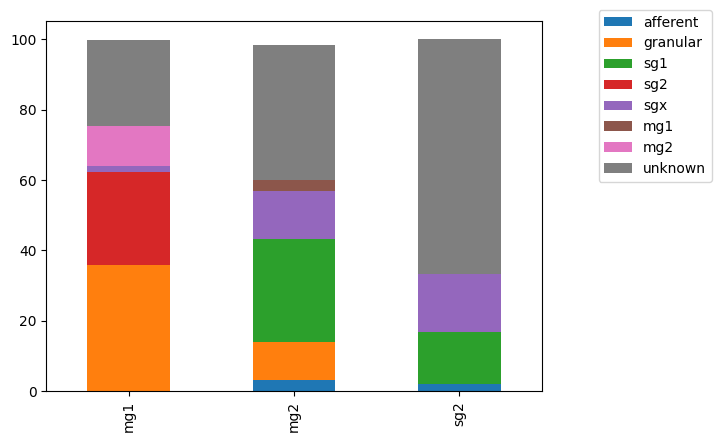

In [12]:
fig = plt.figure()
ax = plt.subplot(111)

pre_type = pd.DataFrame({'afferent': [0,3.1,2.1],
                         'granular': [35.8,10.8,0],
                         'sg1': [0,29.2,14.6],
                         'sg2': [26.4,0,0],
                         'sgx': [1.9,13.8,16.7],
                         'mg1': [0,3.1,0],
                         'mg2':[11.3,0,0],
                         'unknown':[24.5,38.5,66.7]},
                        index=['mg1', 'mg2', 'sg2'])
 
 
pre_type.plot(kind='bar', stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05));

# # Add Title and Labels
# plt.title('Intermediate Students Pass %')
# plt.xlabel('Year')
# plt.ylabel('Percentage Ranges')

In [13]:
pre_type = pre_type.melt(ignore_index = False).reset_index()

Text(0, 0.5, 'Percent pre-synaptic cells')

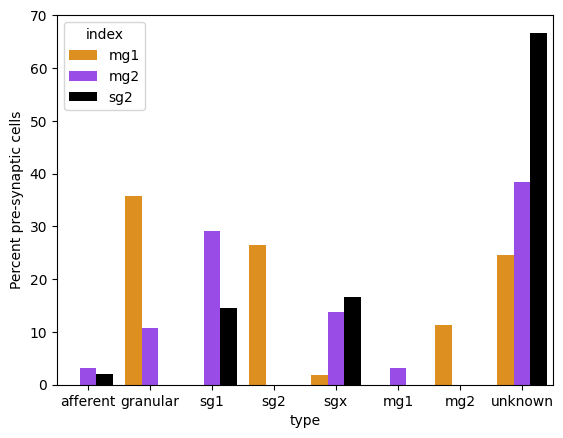

In [14]:
colors = ["#fd9400", "#9934ff","000000"] #color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff'}
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.barplot(data=pre_type, x="variable", y="value", hue="index")
plt.xlabel('type')
plt.ylabel('Percent pre-synaptic cells')

# Channels

## DisInhibition

In [ ]:
# cell_colors = {
#     'mg2' : '#0000ff',
#     'lf' : '#ff0000',
#     'mg1' : '#0000ff',
#     'lg' : '#ff0000',
#     'sgx' : '#0000ff',
#     'sg2' : '#0000ff',
#     'sg1' : '#0000ff',
#     'grc' : '#0000ff',
#     'aff' : '#ff0000',    
# }


In [164]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_386392158__2023-05-22 14.40.21.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)

base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

In [173]:
# nodes = ['214581797',
#          # '299249397',
#         '135497190',
#         # '134492570',
#         #'302714728',
#         #'308471538',
#         '305051491',
#         '228321391',
#         '56569586']

nodes = ['134492570',
         '386392158',
         '389812730',
        '403522169',
        '313068329',
        '668081112']

cell_colors = {
    '134492570' : '#9400D3', 
    '386392158' : '#0000ff',
    '389812730' : '#00FF00',
    '403522169' : '#ffdd00',
    '313068329' : '#ffdd00',#'#ffbf00',#'#FF7F00',
    '668081112' : '#ff0000',    
}

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [160]:
viewer = get_viewer(backgnd_color='white')

create_em_layer(viewer)

In [174]:

for i,x in enumerate(['134492570','386392158']):# = nodes[0]
    lname = cell_type[x] + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    sleep(3)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = cell_colors[x]#'#808080'#gray
        # for bs in cell.cell_data['base_segments']['axon']:
        #     s.layers[lname].segment_colors[int(bs)] = cell_colors[cell_type[x]]

lf_4_134492570
mg2_5_386392158


In [167]:
point_type = 'post-synaptic'

syn_plot = set()
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_to_find = set([point[3] for point in cell.cell_data['end_points'][point_type]])
    
    for n_ in nodes:
        syn_plot=syn_plot.union(syn_to_find.intersection(base_segments[n_]))



syn_all = []
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_all.extend([point for point in cell.cell_data['end_points'][point_type] if point[3] in syn_plot])


with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#ffffff'#'#ff00ff'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(syn_all):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   



In [ ]:
point_type = 'pre-synaptic'

syn_plot = set()
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_to_find = set([point[3] for point in cell.cell_data['end_points'][point_type]])
    
    for n_ in nodes:
        syn_plot=syn_plot.union(syn_to_find.intersection(base_segments[n_]))



syn_all = []
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_all.extend([point for point in cell.cell_data['end_points'][point_type] if point[3] in syn_plot])


with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#ffffff'#'#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(syn_all):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   



## Inhibition

In [115]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_306242528__2023-07-03 09.54.17.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)

base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

In [140]:
nodes = [#'387539479',
         #'389845032',
        '128770984',
        '213501262',
        '228366816',
        '56569586']

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [141]:
viewer = get_viewer(backgnd_color='white')

create_em_layer(viewer)

In [142]:
# cell_colors = {
#     'mg2' : '#0000ff',
#     'lf' : '#ff0000',
#     'mg1' : '#0000ff',
#     'lg' : '#ff0000',
#     'sg2' : '#0000ff',
#     'sg1' : '#0000ff',
#     'grc' : '#0000ff',
#     'aff' : '#ff0000',    
# }
cell_colors = {
    '213501262' : '#0000ff', 
    '128770984' : '#9400D3',
    # '305051491' : '#00FF00',
    '228366816' : '#ffdd00',#'#ffbf00',#'#FF7F00',
    '56569586' : '#ff0000',    
}

for i,x in enumerate(nodes):# = nodes[0]
    lname = cell_type[x] + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    sleep(3)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = cell_colors[x]#'#808080'#'#d2b48c' # blue
        # for bs in cell.cell_data['base_segments']['axon']:
        #     s.layers[lname].segment_colors[int(bs)] = cell_colors[cell_type[x]]

lg_4_128770984
mg1_5_213501262
grc_6_228366816
aff_7_56569586


In [143]:
point_type = 'post-synaptic'

syn_plot = set()
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_to_find = set([point[3] for point in cell.cell_data['end_points'][point_type]])
    
    for n_ in nodes:
        syn_plot=syn_plot.union(syn_to_find.intersection(base_segments[n_]))



syn_all = []
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_all.extend([point for point in cell.cell_data['end_points'][point_type] if point[3] in syn_plot])


with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00ff00'#'#ff00ff'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(syn_all):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   



In [144]:
point_type = 'pre-synaptic'

syn_plot = set()
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_to_find = set([point[3] for point in cell.cell_data['end_points'][point_type]])
    
    for n_ in nodes:
        syn_plot=syn_plot.union(syn_to_find.intersection(base_segments[n_]))



syn_all = []
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_all.extend([point for point in cell.cell_data['end_points'][point_type] if point[3] in syn_plot])


with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00ff00'#'#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(syn_all):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   



# Development

In [183]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child



cell = ecrest(settings_dict,launch_viewer=False)

base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

In [185]:
nodes = ['304031639',
         '303953883',
         '306242528',
         '305051491',
         '387539479',
         '389845032',
        '213501262',
        '308471538',
         '302714728',
         '214581797',
        '228321391',
        '228366816',
        '389812730',
        '403522169',
        '313068329',
        '299496636',
        '668081112']

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [178]:
viewer = get_viewer(backgnd_color='white')

create_em_layer(viewer)

In [186]:
# cell_colors = {
#     'mg2' : '#0000ff',
#     'lf' : '#ff0000',
#     'mg1' : '#0000ff',
#     'lg' : '#ff0000',
#     'sgx' : '#0000ff',
#     'sg2' : '#0000ff',
#     'sg1' : '#0000ff',
#     'grc' : '#0000ff',
#     'aff' : '#ff0000',    
# }
cell_colors = {
    'mg2' : '#0000ff',
    'lf' : '#ff0000',
    'mg1' : '#0000ff',
    'lg' : '#ff0000',
    'sgx' : '#0000ff',
    'sg2' : '#0000ff',
    'sg1' : '#0000ff',
    'grc' : '#0000ff',
    'aff' : '#ff0000',    
}


for i,x in enumerate(['668081112']):# = nodes[0]
    lname = cell_type[x] + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
    sleep(3)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = '#000000'#'#808080'#'#d2b48c' # blue
        for bs in cell.cell_data['base_segments']['axon']:
            s.layers[lname].segment_colors[int(bs)] = cell_colors[cell_type[x]]

aff_4_668081112


# Volume subsample reconstruction

### segments from an NG json into an existing CREST

In [10]:
neuroglancer_path = '/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/volume-subsample-all'
filename = 'base_segs.json'
neuroglancer_path = Path(neuroglancer_path) / filename

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)

In [24]:
segmentation_layer = next((item for item in neuroglancer_data['layers'] if item["source"] == 'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930'), None)
base_segment_list_ng = set(segmentation_layer['segments'])



In [13]:
crest = ecrest(settings_dict,launch_viewer=False)

base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']))

In [25]:
topop=set()
for k,v in base_segments.items():
    if base_segment_list_ng & v != set():
        print(f'use reconstruction {k}')
        topop = topop.union(base_segment_list_ng & v)
    

use reconstruction 217089429
use reconstruction 218095913
use reconstruction 219256490
use reconstruction 219303377
use reconstruction 221561350
use reconstruction 223835257
use reconstruction 224964966
use reconstruction 227301316
use reconstruction 229531331
use reconstruction 298228381
use reconstruction 299404889
use reconstruction 299405462
use reconstruction 299439953
use reconstruction 300565422
use reconstruction 301677416
use reconstruction 301682826
use reconstruction 301693439
use reconstruction 302870802
use reconstruction 305116146
use reconstruction 305130656
use reconstruction 306289985
use reconstruction 306290102
use reconstruction 309693063
use reconstruction 309693374
use reconstruction 309743149
use reconstruction 309755751
use reconstruction 310855106
use reconstruction 310871239
use reconstruction 393280889


In [28]:
base_segment_list_ng = base_segment_list_ng.difference(topop)

In [ ]:
todo_dict = {}
for seedseg in list(base_segment_list_ng):
    cell = ecrest(settings_dict,segment_id = seedseg,launch_viewer=False)
    todo_dict[seedseg] = set(cell.cell_data['base_segments']['unknown'])
    # post_segs_without_cell+=1
    

In [30]:
len(todo_dict)

367

In [31]:
topop=[]

todo_inds = list(todo_dict.keys())
for k,k_ in itertools.combinations(todo_inds,2):
    if todo_dict[k]&todo_dict[k_]!=set():
        # then they share segments
        topop.append(k_)
topop = np.unique(topop)

In [32]:
len(topop)

216

In [33]:
for segid in topop:
    todo_dict.pop(segid)
    

In [34]:
len(todo_dict)

151

In [35]:
for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'volume-subsample-all/in-progress')
    



Creating base segment graph for cell 213563250 Cell Reconstruction
all base locations for 123 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 213563250. No file saved yet -- save manually.
Saved cell 213563250 reconstruction locally at 2023-06-30 16.34.08
Creating base segment graph for cell 214707822 Cell Reconstruction
all base locations for 1570 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstructio